# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.67KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

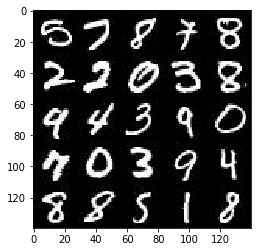

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

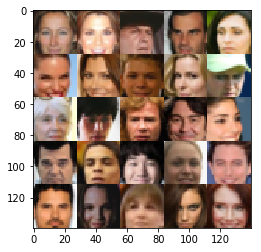

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        lrelu_1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(lrelu_1, 128, 5, 2, 'same')
        bn_2 = tf.layers.batch_normalization(h2, training=True)
        lrelu_2 = tf.maximum(alpha * bn_2, bn_2)
        
        h3 = tf.layers.conv2d(lrelu_2, 256, 5, 2, 'same')
        bn_3 = tf.layers.batch_normalization(h3, training=True)
        lrelu_3 = tf.maximum(alpha * bn_3, bn_3)
        
        flat = tf.reshape(lrelu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 2*2*512)
        bn_1 = tf.reshape(h1, (-1, 2, 2, 512))
        lrelu_1 = tf.maximum(alpha * bn_1, bn_1)
        
        h2 = tf.layers.conv2d_transpose(lrelu_1, 256, 5, strides=2, padding='valid')
        bn_2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu_2 = tf.maximum(alpha * bn_2, bn_2)

        h3 = tf.layers.conv2d_transpose(lrelu_2, 128, 5, strides=2, padding='same')
        bn_3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu_3 = tf.maximum(alpha * bn_3, bn_3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu_3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim) 
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_count = 0
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                batch_count += 1

                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 0.4065... Generator Loss: 1.5211
Epoch 1/2... Discriminator Loss: 0.2086... Generator Loss: 2.0458
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 0.3007... Generator Loss: 2.2617
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 2.4806
Epoch 1/2... Discriminator Loss: 0.2145... Generator Loss: 3.6379
Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 1.6783
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 1.5066
Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 2.1328


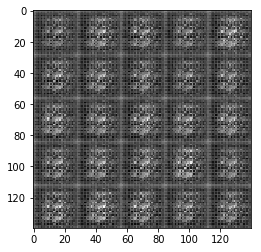

Epoch 1/2... Discriminator Loss: 0.2962... Generator Loss: 1.7943
Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 2.0089
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.7818
Epoch 1/2... Discriminator Loss: 0.2224... Generator Loss: 2.7716
Epoch 1/2... Discriminator Loss: 0.2583... Generator Loss: 2.3281
Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 3.2713
Epoch 1/2... Discriminator Loss: 0.1761... Generator Loss: 2.6479
Epoch 1/2... Discriminator Loss: 0.1400... Generator Loss: 3.6037
Epoch 1/2... Discriminator Loss: 0.2048... Generator Loss: 2.5558


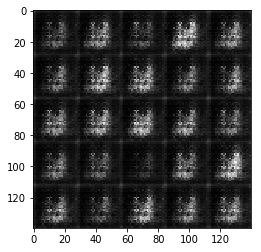

Epoch 1/2... Discriminator Loss: 0.1645... Generator Loss: 3.0087
Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 3.1348
Epoch 1/2... Discriminator Loss: 0.0854... Generator Loss: 3.4035
Epoch 1/2... Discriminator Loss: 0.2427... Generator Loss: 3.5692
Epoch 1/2... Discriminator Loss: 0.0738... Generator Loss: 3.6425
Epoch 1/2... Discriminator Loss: 0.0991... Generator Loss: 3.1207
Epoch 1/2... Discriminator Loss: 0.1069... Generator Loss: 3.1589
Epoch 1/2... Discriminator Loss: 0.1452... Generator Loss: 2.8147
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.2728
Epoch 1/2... Discriminator Loss: 0.1190... Generator Loss: 4.1224


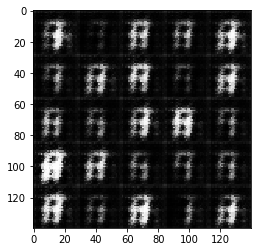

Epoch 1/2... Discriminator Loss: 0.0611... Generator Loss: 3.4711
Epoch 1/2... Discriminator Loss: 0.0974... Generator Loss: 3.3640
Epoch 1/2... Discriminator Loss: 0.1354... Generator Loss: 3.1850
Epoch 1/2... Discriminator Loss: 0.1705... Generator Loss: 2.4612
Epoch 1/2... Discriminator Loss: 0.1915... Generator Loss: 2.8869
Epoch 1/2... Discriminator Loss: 0.2447... Generator Loss: 2.4583
Epoch 1/2... Discriminator Loss: 0.4686... Generator Loss: 9.4961
Epoch 1/2... Discriminator Loss: 0.2869... Generator Loss: 2.0816
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 1.9107
Epoch 1/2... Discriminator Loss: 0.1625... Generator Loss: 2.9071


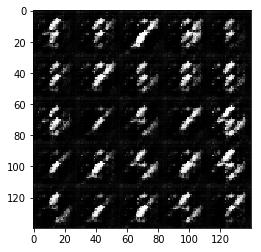

Epoch 1/2... Discriminator Loss: 0.1100... Generator Loss: 3.3218
Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 3.1340
Epoch 1/2... Discriminator Loss: 0.1791... Generator Loss: 3.1254
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 4.9949
Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 2.3138
Epoch 1/2... Discriminator Loss: 0.2705... Generator Loss: 2.7544
Epoch 1/2... Discriminator Loss: 0.2006... Generator Loss: 3.2003
Epoch 1/2... Discriminator Loss: 0.3124... Generator Loss: 3.5009
Epoch 1/2... Discriminator Loss: 0.1403... Generator Loss: 2.9131
Epoch 1/2... Discriminator Loss: 0.3170... Generator Loss: 2.6118


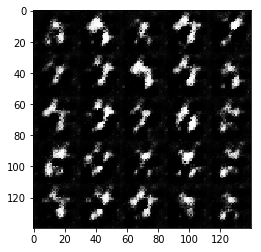

Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.1502
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 3.9615
Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 2.4132
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 6.3148
Epoch 1/2... Discriminator Loss: 0.2692... Generator Loss: 3.5650
Epoch 1/2... Discriminator Loss: 0.2392... Generator Loss: 2.6757
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.8442
Epoch 1/2... Discriminator Loss: 0.2571... Generator Loss: 2.4761
Epoch 1/2... Discriminator Loss: 0.2108... Generator Loss: 2.5626
Epoch 1/2... Discriminator Loss: 0.2565... Generator Loss: 2.7086


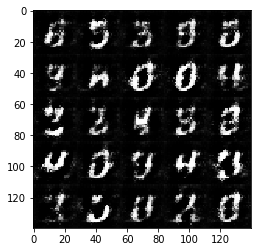

Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 3.0016
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 3.7278
Epoch 1/2... Discriminator Loss: 0.1963... Generator Loss: 2.9816
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 1.8398
Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 4.0272
Epoch 1/2... Discriminator Loss: 0.1595... Generator Loss: 3.9528
Epoch 1/2... Discriminator Loss: 0.2980... Generator Loss: 2.3711
Epoch 1/2... Discriminator Loss: 0.1944... Generator Loss: 3.0427
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 1.9304


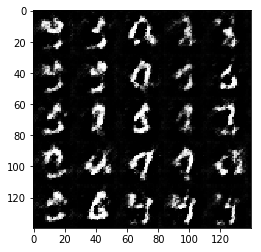

Epoch 1/2... Discriminator Loss: 0.3107... Generator Loss: 2.2741
Epoch 1/2... Discriminator Loss: 0.4354... Generator Loss: 3.3882
Epoch 1/2... Discriminator Loss: 0.4145... Generator Loss: 1.8896
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 3.6872
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 1.8692
Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 2.2588
Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 1.9028
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 2.1948
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 1.7232
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.4866


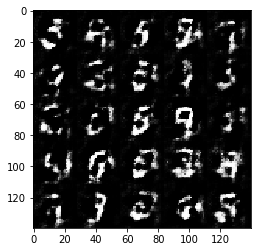

Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 2.5608
Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 1.2828
Epoch 1/2... Discriminator Loss: 0.3444... Generator Loss: 2.6233
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.3210
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 2.2868
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 2.7826
Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 5.6384
Epoch 1/2... Discriminator Loss: 0.4187... Generator Loss: 2.1967
Epoch 1/2... Discriminator Loss: 0.5325... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 1.9357


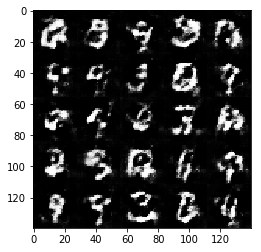

Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 3.1396
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 3.2737
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.7934
Epoch 2/2... Discriminator Loss: 0.4882... Generator Loss: 1.6257
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.4139
Epoch 2/2... Discriminator Loss: 0.5591... Generator Loss: 2.4382
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.6080
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.1494
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 3.9942
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.0864


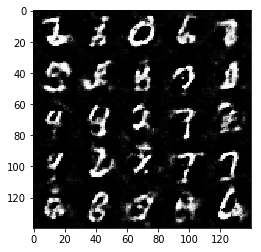

Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.5006
Epoch 2/2... Discriminator Loss: 0.5642... Generator Loss: 2.9574
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 2.5240
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.5413
Epoch 2/2... Discriminator Loss: 0.4299... Generator Loss: 2.1073
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.7276
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.7681
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 2.0331


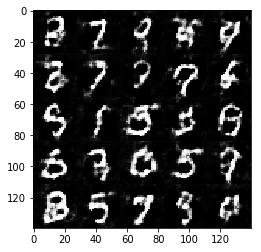

Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 2.6569
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 1.4298
Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 2.1712
Epoch 2/2... Discriminator Loss: 0.5442... Generator Loss: 1.9816
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 2.3976
Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 1.8069
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 0.8841


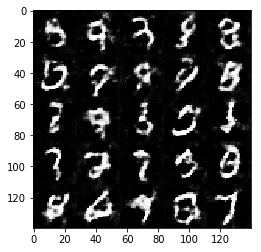

Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 0.5205... Generator Loss: 2.0233
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 2.7909
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.2675
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 2.0768
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 2.2506
Epoch 2/2... Discriminator Loss: 0.4727... Generator Loss: 1.9147
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.6829
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 0.6341


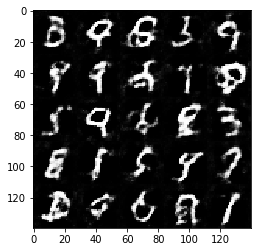

Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 2.0967
Epoch 2/2... Discriminator Loss: 0.4556... Generator Loss: 1.8925
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 2.3354
Epoch 2/2... Discriminator Loss: 0.6149... Generator Loss: 1.7801
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 1.5528
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 0.5847... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 2.6398
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 0.7039


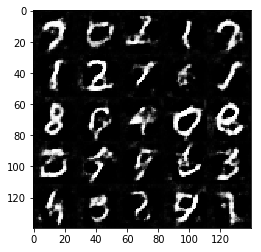

Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.2693
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 1.9956
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.9982
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 2.2804
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 2.4986
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.4053


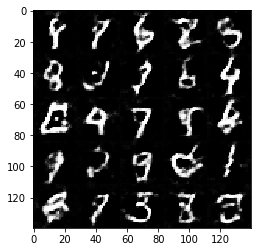

Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.2140
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 1.7510
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 3.0659
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 1.6562
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.7064
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.6258
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 2.0594
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.7897
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 2.1091


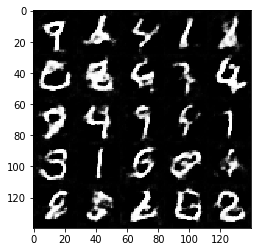

Epoch 2/2... Discriminator Loss: 0.5595... Generator Loss: 1.6758
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 1.0288
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.3727
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 1.5801
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 2.0633
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.3502
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.5404
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.4870


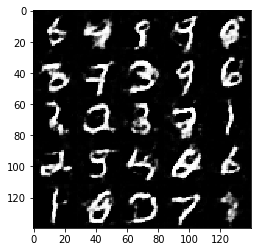

Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.0975
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.1711
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.8639
Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.3580
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.6164
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.0807


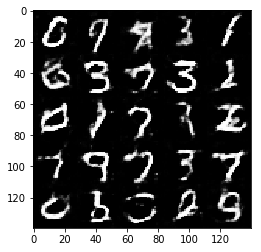

Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 2.1283
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 1.2324
Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 2.0682
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.2883


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 0.4421
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 1.7702
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 2.9521
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 1.9788
Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 2.5551


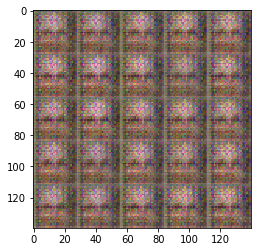

Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 2.0184
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 2.9968
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 2.8193
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 3.0861
Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.2602... Generator Loss: 2.5267
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.4311
Epoch 1/1... Discriminator Loss: 0.1442... Generator Loss: 4.6933
Epoch 1/1... Discriminator Loss: 0.1177... Generator Loss: 2.9553
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 2.8531


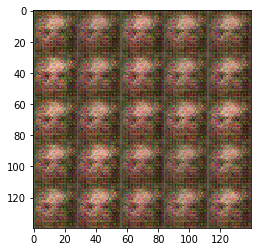

Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 2.3276
Epoch 1/1... Discriminator Loss: 0.1320... Generator Loss: 3.1651
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 3.6971
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.8108
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.1838
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.7745
Epoch 1/1... Discriminator Loss: 0.1351... Generator Loss: 2.7178
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 3.5514
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.2904
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 4.0267


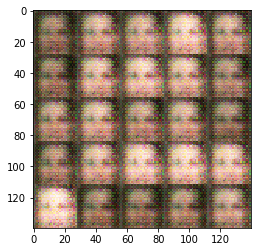

Epoch 1/1... Discriminator Loss: 0.2014... Generator Loss: 3.8956
Epoch 1/1... Discriminator Loss: 0.2959... Generator Loss: 2.0591
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 4.8006
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 3.1128
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 3.5724
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 0.2709... Generator Loss: 1.8984
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 1.7484
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 1.5612


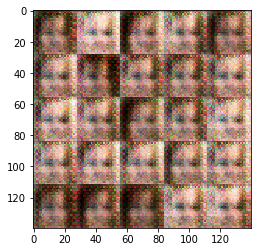

Epoch 1/1... Discriminator Loss: 0.2371... Generator Loss: 3.9323
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 1.7066
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 3.2065
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 2.1505
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.4233


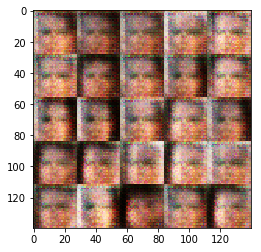

Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 2.9569
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 1.6043


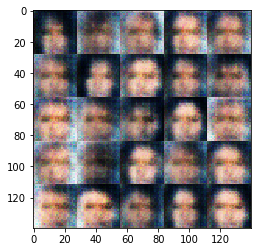

Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 2.2650
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 2.3667
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.6260


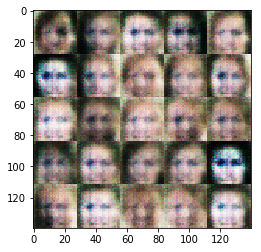

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.9039
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 2.1530
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.4229


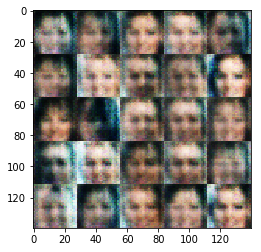

Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.8295


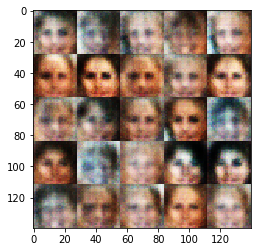

Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9254


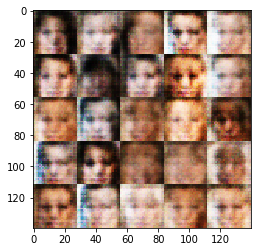

Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9418


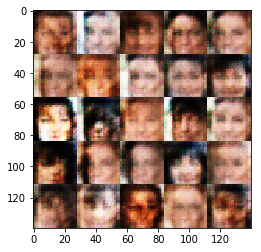

Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.2745


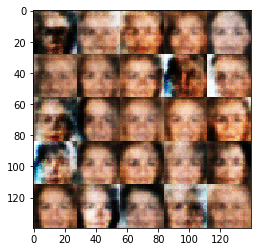

Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.0854


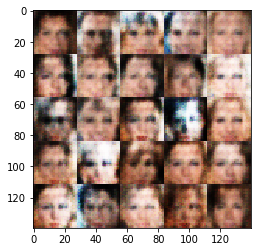

Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.2279


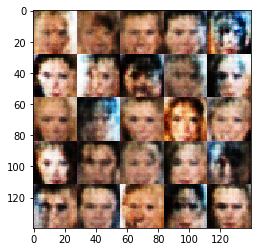

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.5409


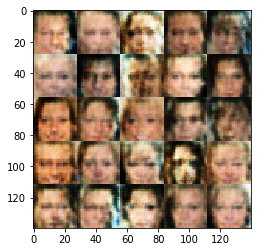

Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.1663


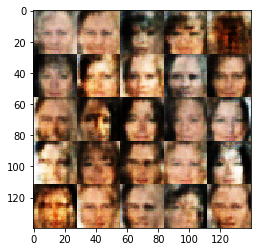

Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.5887


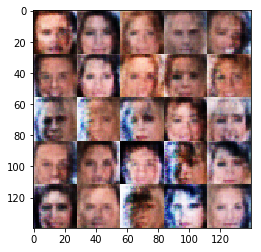

Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.8867


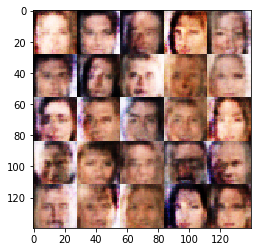

Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.9257


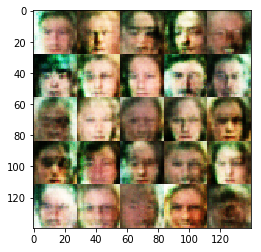

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.4779
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0592


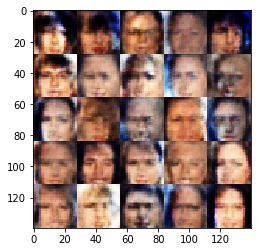

Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.0777


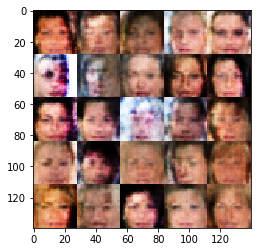

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.4820
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.5184
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.3712


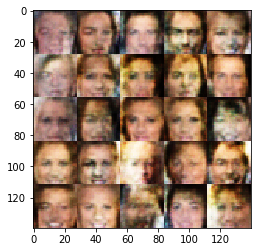

Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8040


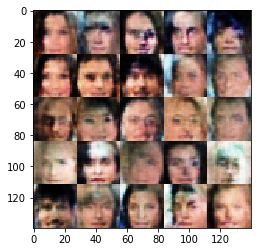

Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.4969


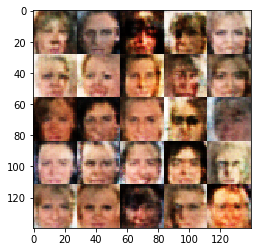

Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.0789


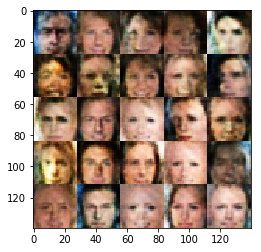

Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.6879


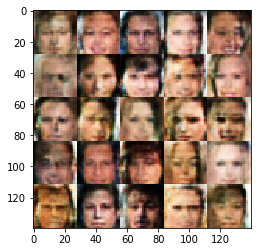

Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.0961


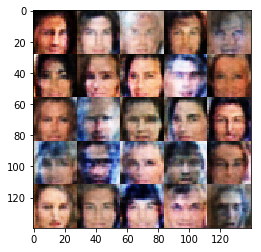

Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 0.9587


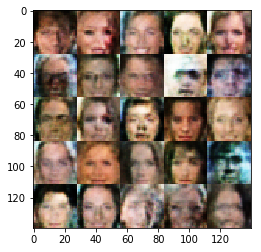

Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.9487


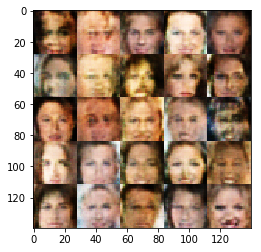

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.4242


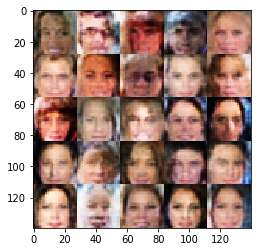

Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7060


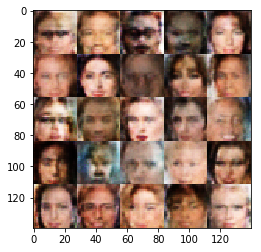

Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.7068


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.